In [1]:
import sys
import importlib
sys.path.append("/users/jmduchar/data/jmduchar/Research/mcgill25/rfi_characterization/")
import python.utils as ut

import os
import numpy as np
import arviz as az
from numpy.polynomial.legendre import legvander
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel
import json
import glob
from scipy.stats import norm, cauchy, mode, t
from cmdstanpy import from_csv
import seaborn as sns
from tqdm import tqdm
import corner
import json

plt.style.use('seaborn-v0_8')

/users/jmduchar/data/jmduchar/Research/mcgill25/rfi_characterization/python/utils.py:318: SyntaxWarning: invalid escape sequence '\s'
  lw=2, label=f"Empirical N(0, $\sigma$ = {empirical_std:.2f})",


In [2]:
outputs = glob.glob("../stan/stan_out/legendre-20251028203016_*.csv")

fit = from_csv(outputs)

22:51:38 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1000 iterations at max treedepth (100.0%)
	Chain 2 had 7 divergent transitions (0.7%)
	Chain 3 had 2 divergent transitions (0.2%)
	Chain 4 had 4 divergent transitions (0.4%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [3]:
print(fit.diagnose())

Checking sampler transitions treedepth.
1000 of 1000 (100.00%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
13 of 1000 (1.30%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
The E-BFMI, 0.00, is below the nominal threshold of 0.30 which suggests that HMC may have trouble exploring the target distribution.
If possible, try to reparameterize the model.

Rank-normalized split effective sample size satisfactory for all parameters.

The following parameters had rank-normalized split R-hat greater than 1.01:
  thet

In [4]:
# Load JSON data

with open(
    "/users/jmduchar/data/jmduchar/Research/mcgill25/rfi_characterization/data/json/legendre_supervised.json",
    "r"
) as f:
    data_dict = json.load(f)

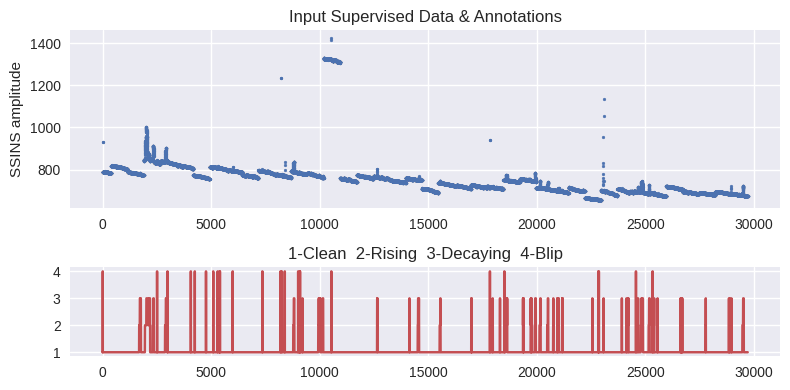

In [5]:
ut.plot_supervised_inputs(data_dict, pointing='p0')

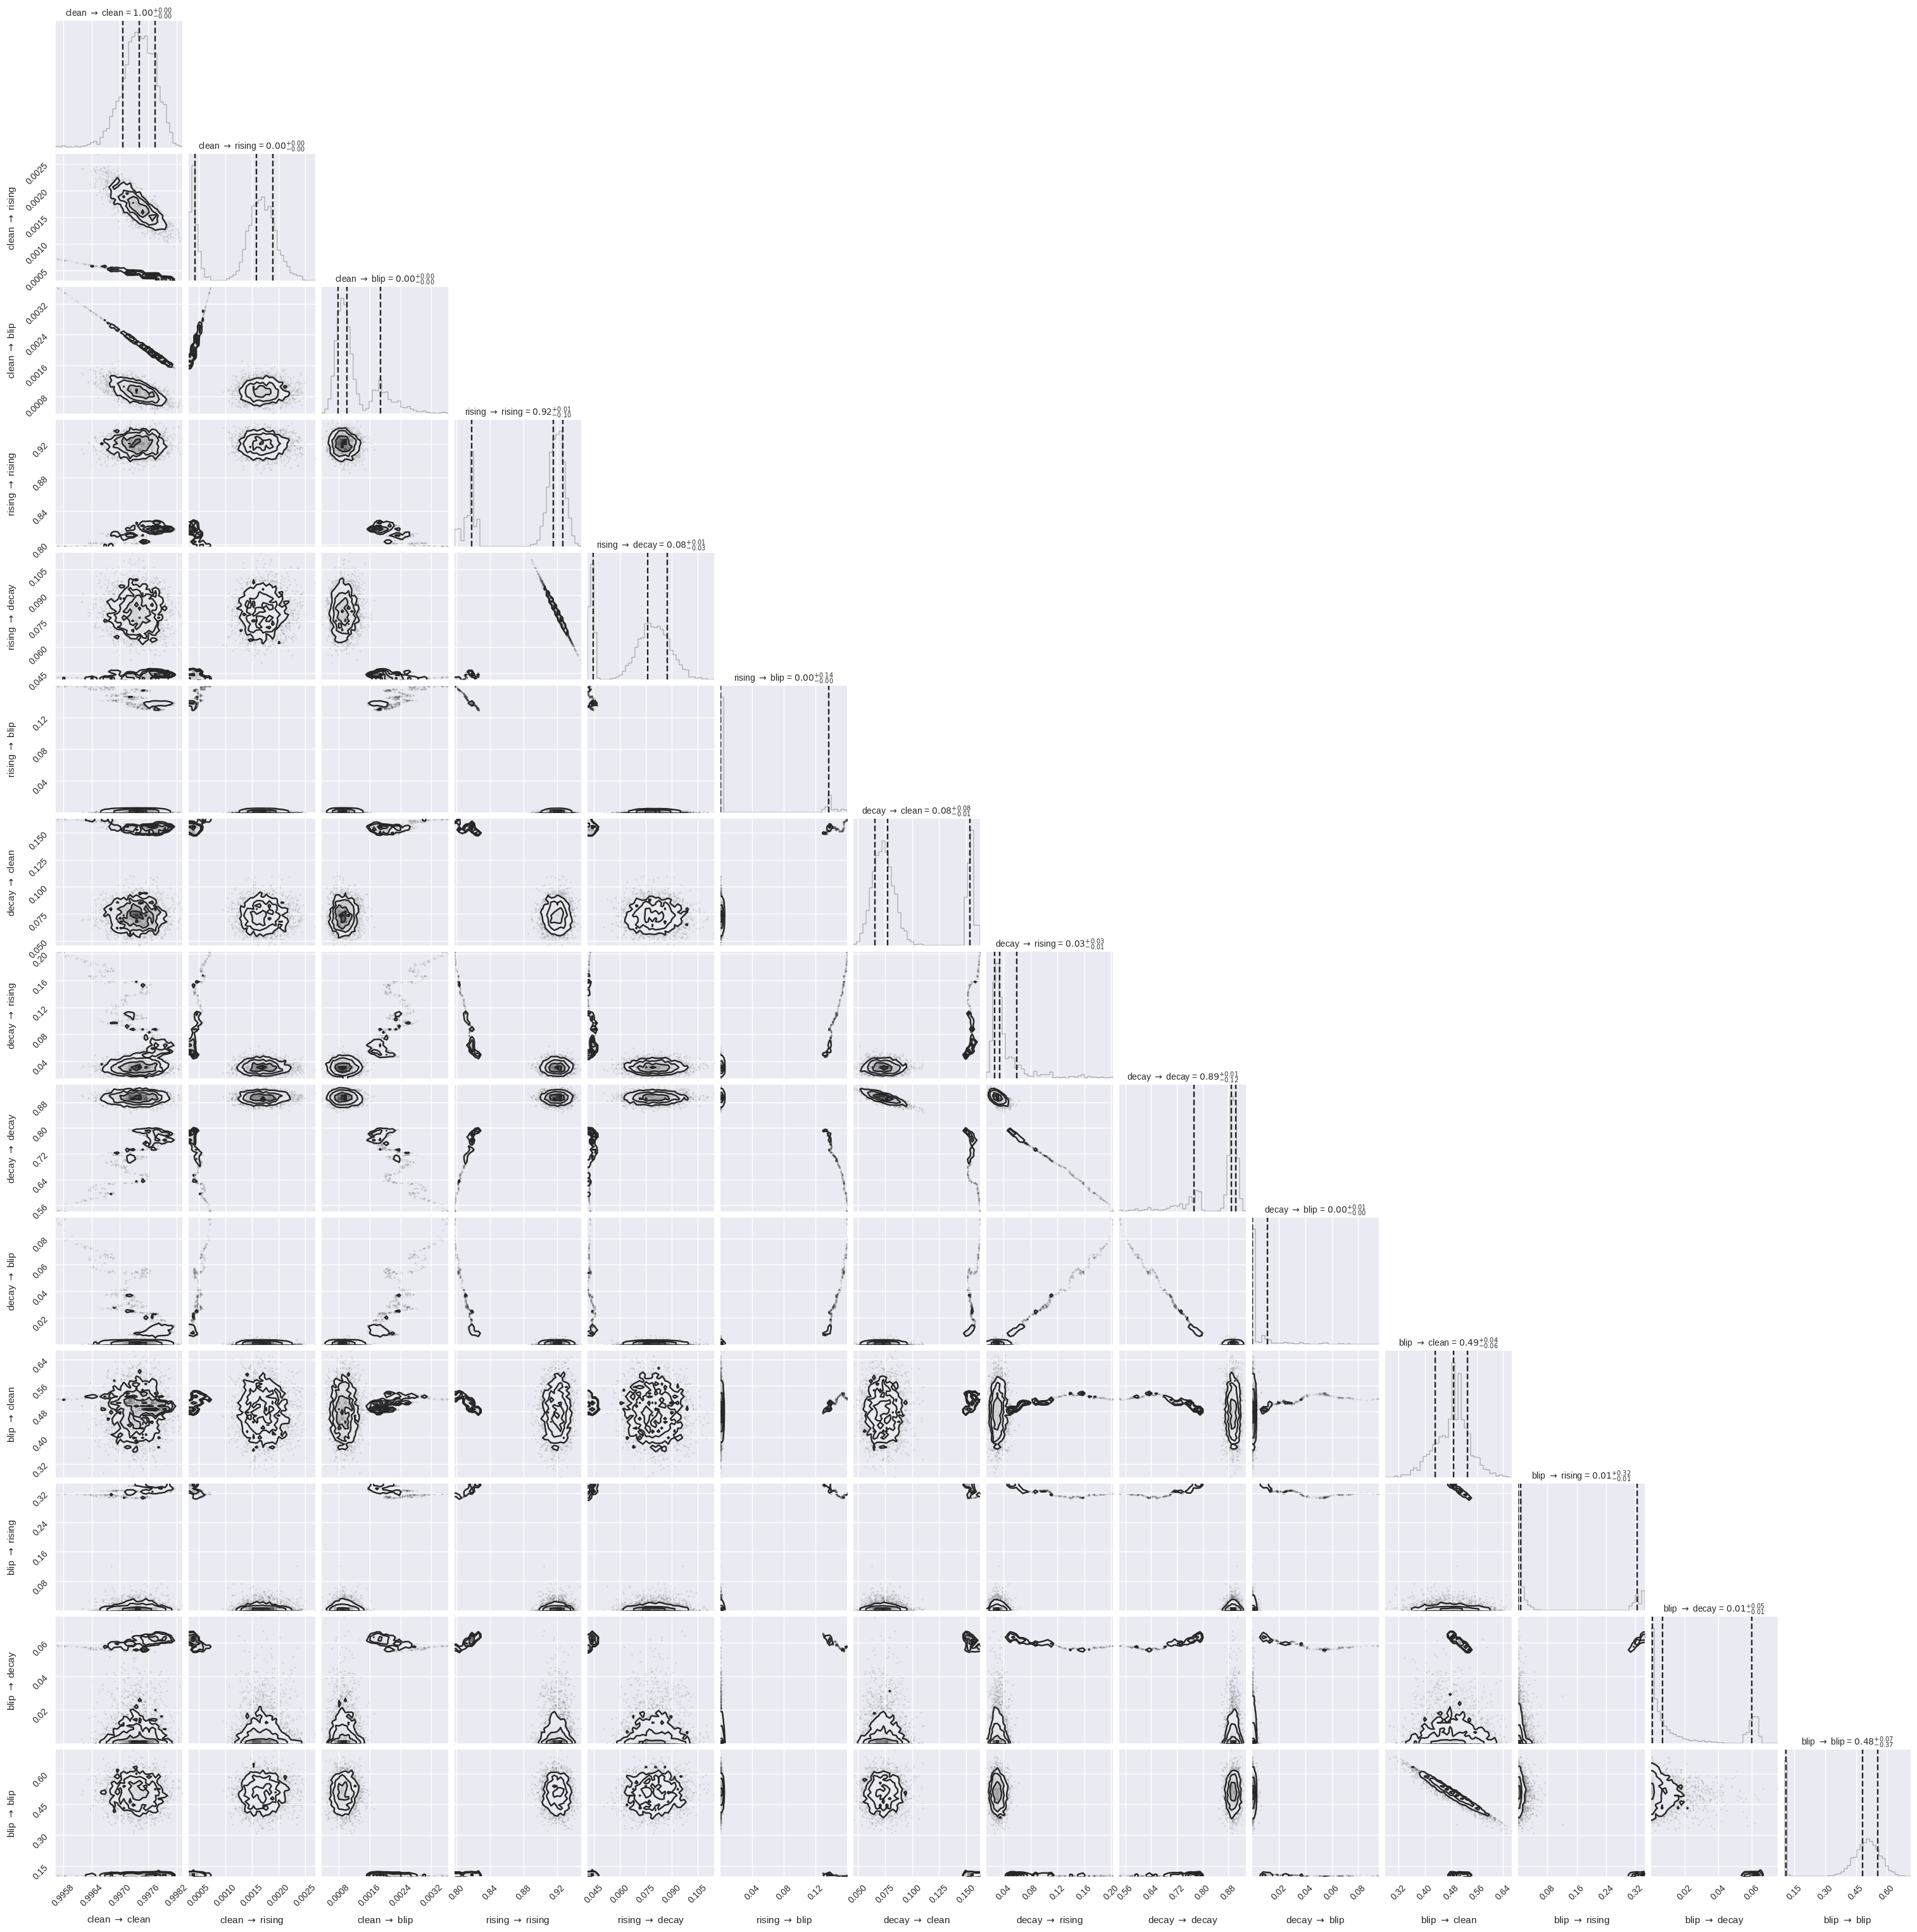

In [6]:
importlib.reload(ut)

ut.transition_corner_plot(fit, save_path=None)

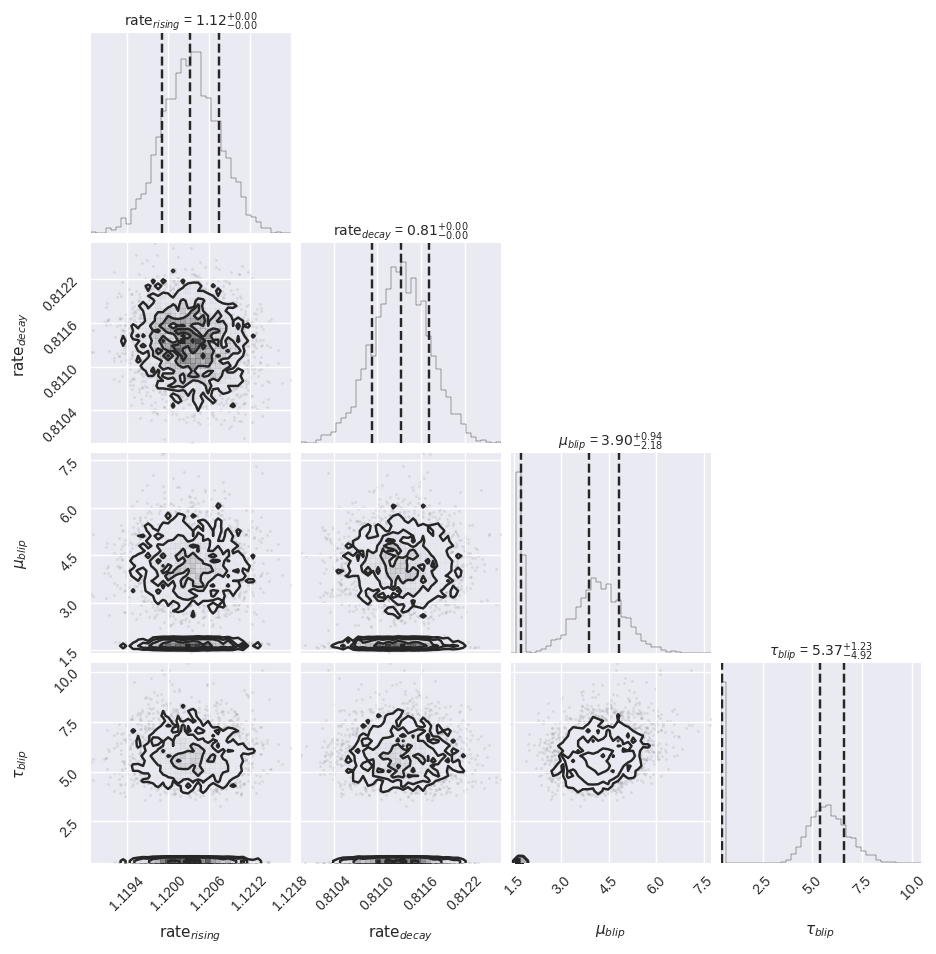

In [7]:
importlib.reload(ut)

ut.emission_corner_plot(fit, save_path=None)

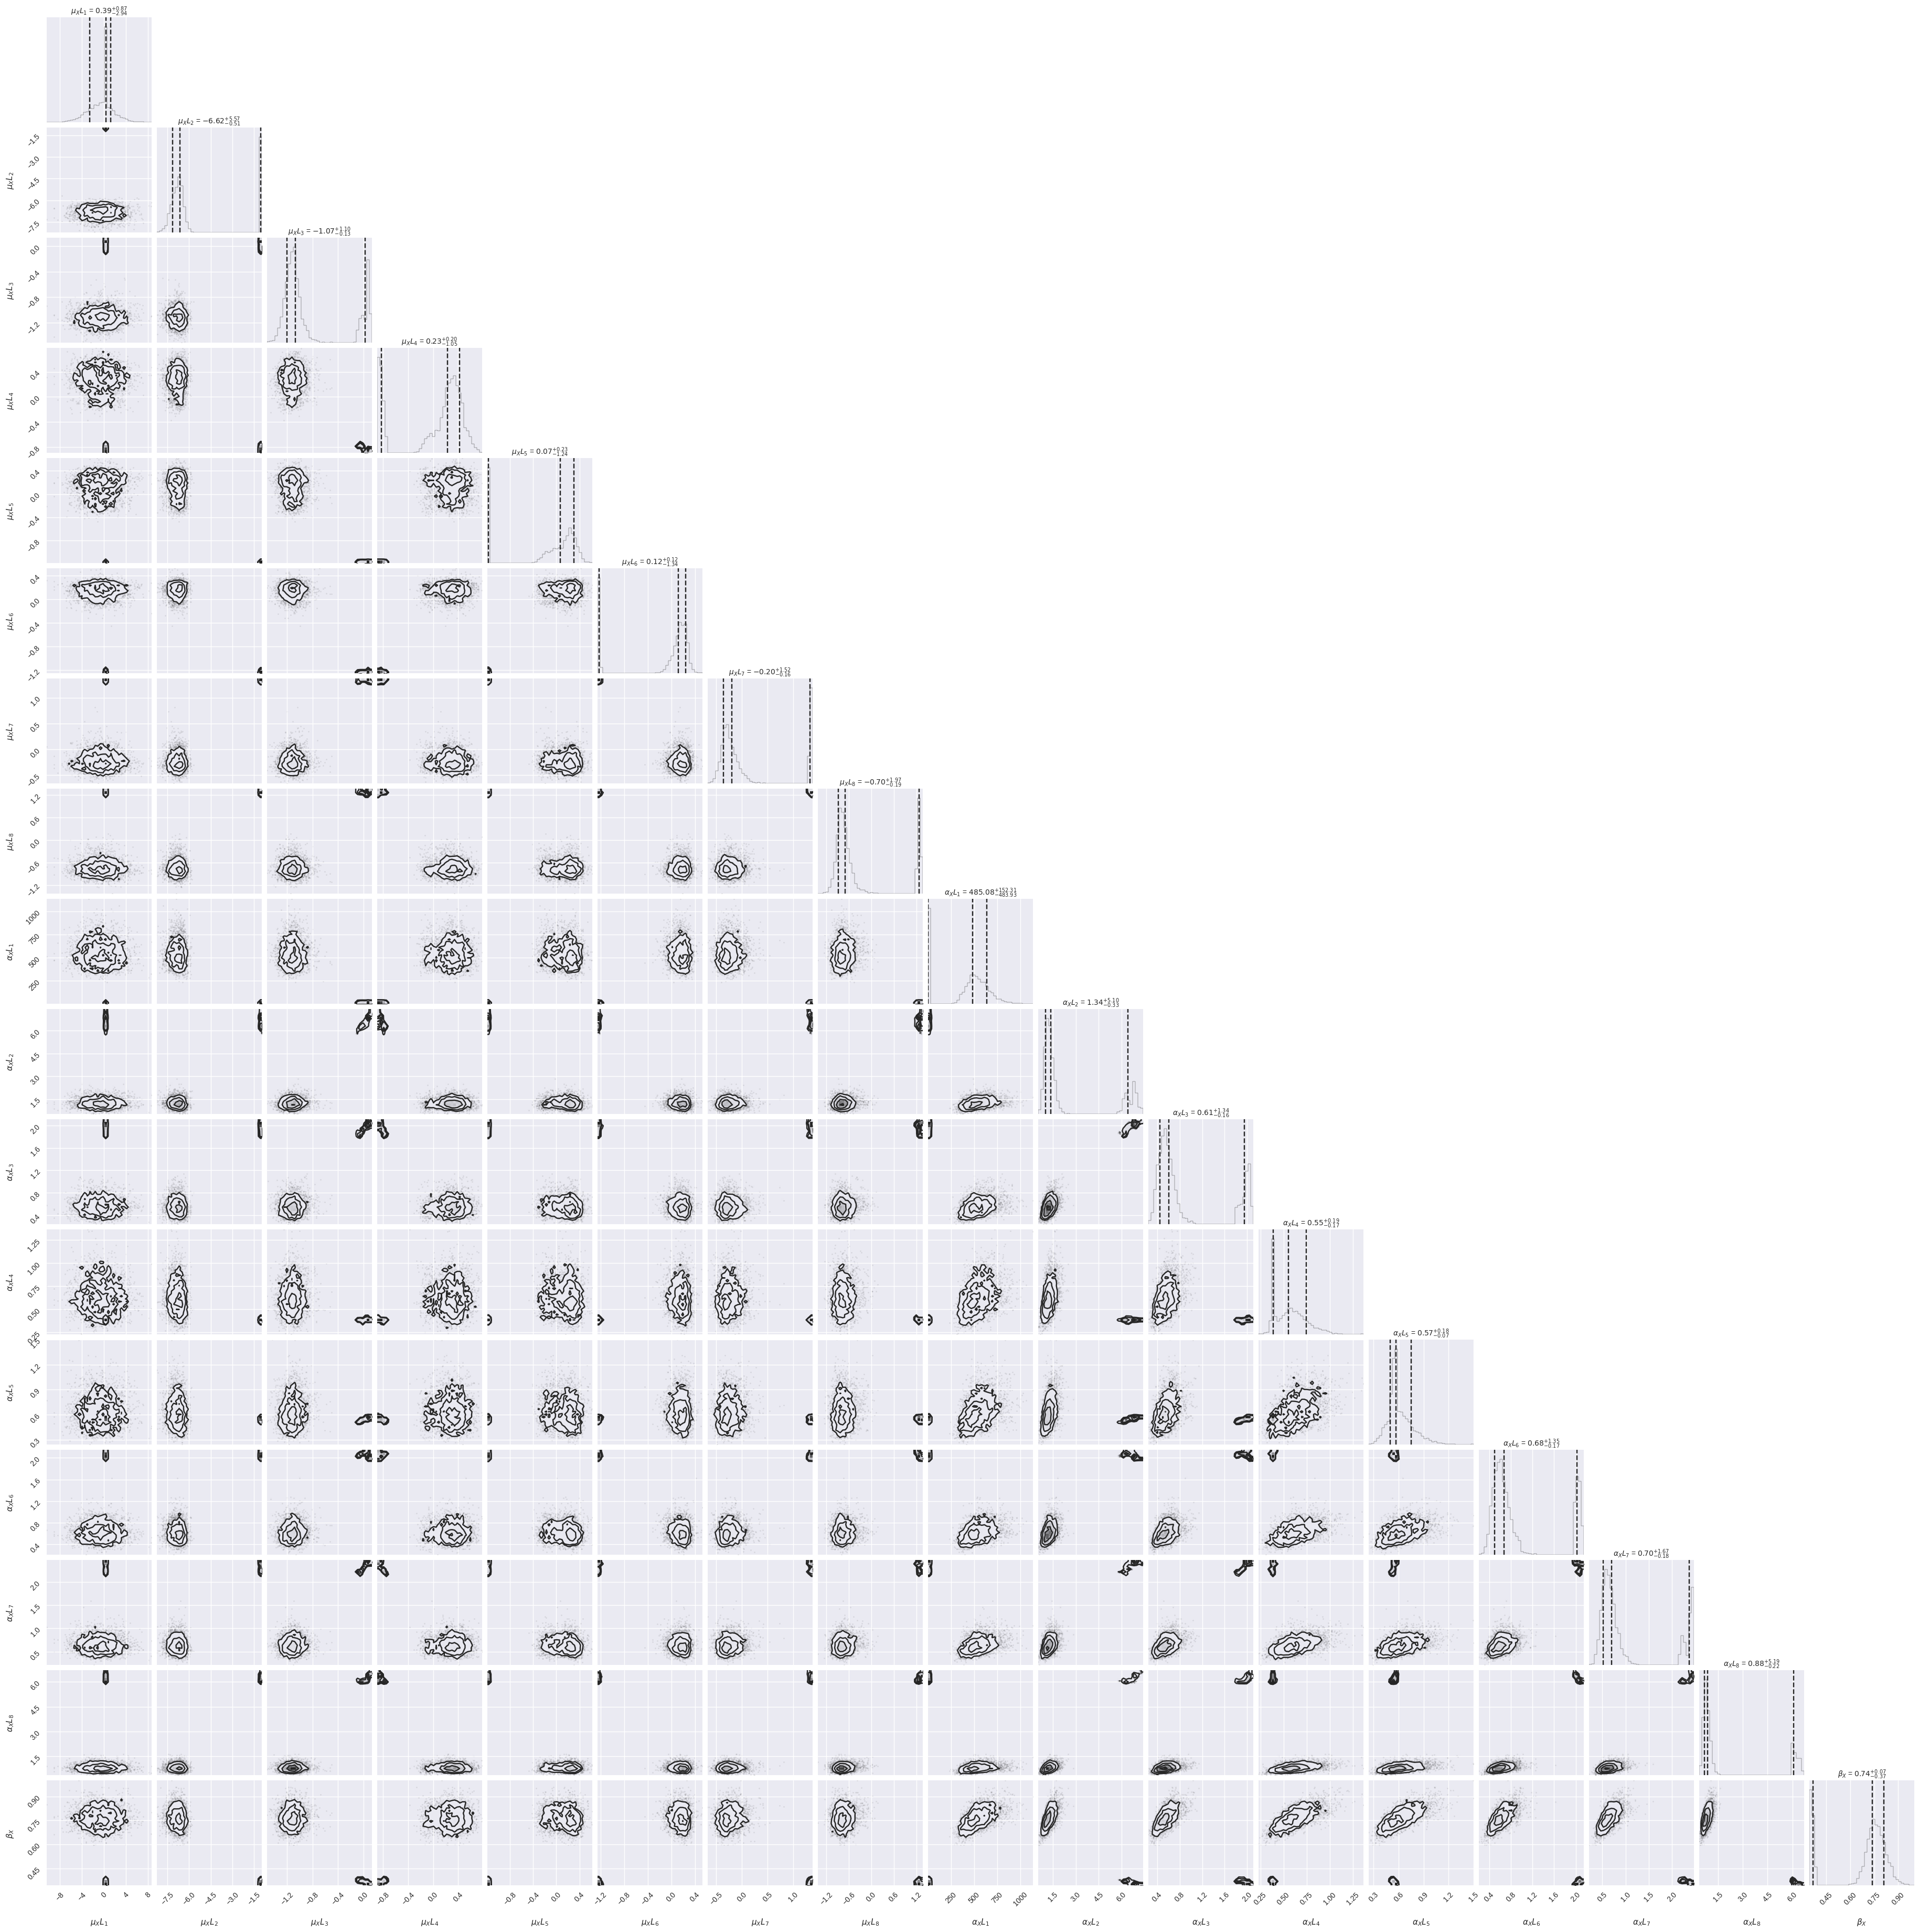

In [8]:
importlib.reload(ut)

ut.legendre_corner_plot(fit, save_path=None)

In [9]:
X = fit.stan_variables()["X_sup"]  # (draws, M_sup, L)
A = np.asarray(data_dict["A_sup"])  # (N_sup, L)
y = np.asarray(data_dict["y_sup"])  # (N_sup,)

start = np.asarray(data_dict["start_idx_sup"]) - 1  # 0-based indexing
stop  = np.asarray(data_dict["stop_idx_sup"])       # Python slice is exclusive

draws, M_sup, L = X.shape
N_sup = len(y)

mu_draws = np.zeros((draws, N_sup))

for m in range(M_sup):
    a, b = start[m], stop[m]
    mu_draws[:, a:b] = X[:, m, :] @ A[a:b, :].T

bg = mu_draws.mean(axis=0)  # (N_sup,)

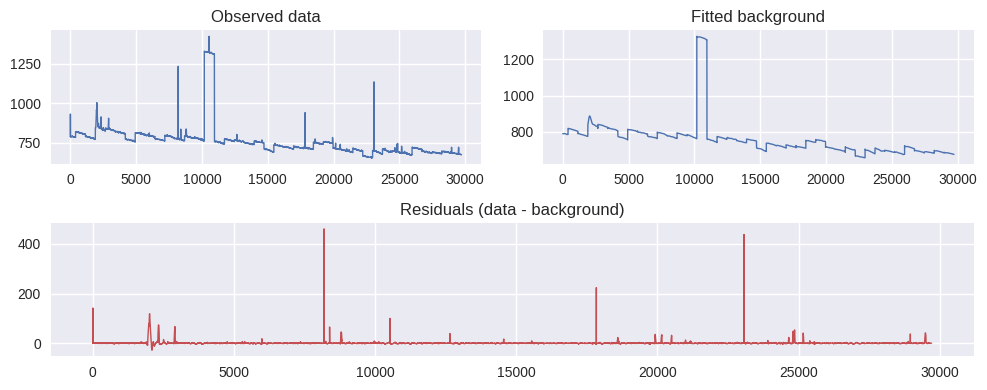

In [10]:
# Restrict viewing range
start = None
end = None

res = y - bg

fig = plt.figure(figsize=(10, 4))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

# Top-left: data
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(y[start:end], linewidth=1)
ax1.set_title("Observed data")

# Top-right: background
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(bg[start:end], linewidth=1)
ax2.set_title("Fitted background")

# Bottom: residuals (full width)
ax3 = fig.add_subplot(gs[1, :])
ax3.plot(res[start:end], linewidth=1, color=sns.color_palette()[2])
ax3.set_title("Residuals (data - background)")

plt.tight_layout()
plt.show()

In [11]:
# We can use these to inform priors on subsequent runs

print("rate_rising:", np.mean(fit.stan_variable('rate_rising')), np.std(fit.stan_variable('rate_rising')))
print("rate_decay:", np.mean(fit.stan_variable('rate_decay')), np.std(fit.stan_variable('rate_decay')))
print("mu_blip:", np.mean(fit.stan_variable('mu_blip')), np.std(fit.stan_variable('mu_blip')))
print("k_blip:", np.mean(fit.stan_variable('k_blip')), np.std(fit.stan_variable('k_blip')))
print("mu_X:", np.mean(fit.stan_variable('mu_X')), np.std(fit.stan_variable('mu_X')))
print("alpha_X:", np.mean(fit.stan_variable('alpha_X')), np.std(fit.stan_variable('alpha_X')))
print("beta_X:", np.mean(fit.stan_variable('beta_X')), np.std(fit.stan_variable('beta_X')))

rate_rising: 1.1203282574999998 0.0004167546504764515
rate_decay: 0.811322585 0.00039696154571318475
mu_blip: 3.59449972 1.2993045985882878
k_blip: 13.642864677500002 7.581149979566484
mu_X: -0.8761980885785967 2.158443197730277
alpha_X: 52.4944646696875 163.66120835743845
beta_X: 0.66480610325 0.18189727642355474
